In [257]:
import datetime as dt
import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [258]:
from calval_etl.utilities.mark_data_access import (
    query_constructor,
    get_db_data,
    get_user_db_creds,
)

In [259]:
db_info = get_user_db_creds("jacob_goldberg", "alp")
db_info_als = get_user_db_creds("jacob_goldberg", "als")

In [260]:
start = dt.datetime(2021, 3, 1)
end = dt.datetime (2021, 10, 30)

In [261]:
ET100_mark_id = 'C006734'
ET75_mark_id = 'C006802'

### Pull Mark 2 data

In [262]:
# hourly
query = query_constructor("hourly", ET100_mark_id, start, end)
mark_hourly_ET100 = get_db_data(db_info, query)

query = query_constructor("hourly", ET75_mark_id, start, end)
mark_hourly_ET75 = get_db_data(db_info, query)

# daily 
query = query_constructor("daily", ET100_mark_id, start, end)
mark_daily_ET100 = get_db_data(db_info, query)

query = query_constructor("daily", ET75_mark_id, start, end)
mark_daily_ET75 = get_db_data(db_info, query)

#### pull the hourly pressure switch data

In [263]:
## device 1
query = query_constructor("irrigation_runtime_hourly", ET100_mark_id, start, end)
irrigation_hourly_ET100 = get_db_data(db_info, query)
## device 2
query = query_constructor("irrigation_runtime_hourly", ET75_mark_id, start, end)
irrigation_hourly_ET75 = get_db_data(db_info_als, query)

#### Calculate irrigation volume 

In [264]:
##ET100

rate = 1.54 #mm/hr

irrigation_hourly_ET100['fixed_seconds'] = irrigation_hourly_ET100['duration_seconds'].apply(lambda x: x if x <=3600 else 3600)
irrigation_hourly_ET100['irigation'] = (irrigation_hourly_ET100['fixed_seconds'] / 3600) * rate  

# Set 'Name' as the index of the dataframe
irrigation_hourly_ET100.set_index('time', inplace=True)
irrigation_hourly_ET100.index

# Resample to daily  sum and save as new dataframe
irrigation_daily_ET100 = irrigation_hourly_ET100.resample('D').sum()
irrigation_daily_ET100=irrigation_daily_ET100.reset_index()


In [265]:
irrigation_daily_ET100

,time,duration_seconds,fixed_seconds,irigation
0,2021-05-07 00:00:00+00:00,4800.0,4800.0,2.053333
1,2021-05-08 00:00:00+00:00,0.0,0.0,0.000000
2,2021-05-09 00:00:00+00:00,4800.0,4800.0,2.053333
3,2021-05-10 00:00:00+00:00,0.0,0.0,0.000000
4,2021-05-11 00:00:00+00:00,0.0,0.0,0.000000
...,...,...,...,...
108,2021-08-23 00:00:00+00:00,14100.0,14100.0,6.031667
109,2021-08-24 00:00:00+00:00,14100.0,14100.0,6.031667
110,2021-08-25 00:00:00+00:00,0.0,0.0,0.000000
111,2021-08-26 00:00:00+00:00,14100.0,14100.0,6.031667


In [266]:
##ET75
rate = 1.56 #mm/hr

irrigation_hourly_ET75['fixed_seconds'] = irrigation_hourly_ET75['duration_seconds'].apply(lambda x: x if x <=3600 else 3600)
irrigation_hourly_ET75['irrigation'] = (irrigation_hourly_ET75['fixed_seconds'] / 3600) * rate  

# Set 'Name' as the index of the dataframe
irrigation_hourly_ET75.set_index('time', inplace=True)
irrigation_hourly_ET75.index

# Resample to daily  sum and save as new dataframe
irrigation_daily_ET75 = irrigation_hourly_ET75.resample('D').sum()
irrigation_daily_ET75=irrigation_daily_ET75.reset_index()


#### pull sentek soil moisture data

In [267]:
query = query_constructor("sentek_hourly", ET100_mark_id, start, end)
sentek_hourly_ET100 = get_db_data(db_info, query)

query = query_constructor("sentek_hourly", ET75_mark_id, start, end)
sentek_hourly_ET75 = get_db_data(db_info, query)

In [268]:
sentek_daily_ET100 = (
    sentek_hourly_ET100.resample("1d", on="time").mean().reset_index()
)


sentek_daily_ET75 = (
    sentek_hourly_ET75.resample("1d", on="time").mean().reset_index()
)


In [269]:
sentek_daily_ET100 

,time,num_of_sensors,moisture_0_min,moisture_0_max,moisture_0_mean,moisture_1_min,moisture_1_max,moisture_1_mean,moisture_2_min,moisture_2_max,...,temp_2_mean,temp_3_min,temp_3_max,temp_3_mean,temp_4_min,temp_4_max,temp_4_mean,temp_5_min,temp_5_max,temp_5_mean
0,2021-05-04 00:00:00+00:00,6,36.377000,38.255500,37.222057,44.295000,44.724500,44.458784,47.726500,47.883000,...,22.900386,22.551000,22.767000,22.622792,22.088500,22.326500,22.186080,21.147500,21.279500,21.230459
1,2021-05-05 00:00:00+00:00,6,32.848042,33.073792,32.958923,44.161167,44.232250,44.196952,48.225625,48.276042,...,23.238973,22.725833,22.820125,22.773139,22.155542,22.253417,22.197459,21.134458,21.212250,21.175102
2,2021-05-06 00:00:00+00:00,6,31.619750,31.771250,31.695406,44.390542,44.449917,44.419958,48.150708,48.198417,...,23.847573,23.261750,23.352042,23.308760,22.600833,22.678167,22.635826,21.536667,21.602750,21.578552
3,2021-05-07 00:00:00+00:00,6,30.850458,30.997542,30.921996,44.155667,44.223792,44.187527,47.916792,47.964625,...,23.399618,23.168542,23.252917,23.208075,22.740167,22.826542,22.777271,21.802125,21.892792,21.853095
4,2021-05-08 00:00:00+00:00,6,30.498042,30.608167,30.553153,44.296875,44.357750,44.327021,47.861500,47.904750,...,23.387656,23.096083,23.183250,23.135219,22.702125,22.770708,22.735185,21.821292,21.907625,21.868172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2021-09-16 00:00:00+00:00,6,21.226458,21.272833,21.248104,33.387167,33.428208,33.407974,25.267333,25.301417,...,21.061680,21.274583,21.399750,21.334084,21.332208,21.444333,21.384806,20.913625,20.949000,20.941677
136,2021-09-17 00:00:00+00:00,6,21.064083,21.116875,21.091134,33.262542,33.307083,33.285107,24.972917,25.004875,...,20.723645,21.004417,21.122208,21.055845,21.138333,21.246917,21.190702,20.771708,20.846542,20.803685
137,2021-09-18 00:00:00+00:00,6,20.979125,21.026625,21.003872,33.181083,33.222042,33.203288,24.726958,24.753958,...,20.471632,20.776583,20.898917,20.837056,20.919125,21.039833,20.976660,20.578375,20.672083,20.620215
138,2021-09-19 00:00:00+00:00,6,20.974208,21.011208,20.991538,33.164917,33.205958,33.185157,24.561542,24.590417,...,20.488824,20.693208,20.826792,20.757222,20.750458,20.873083,20.805470,20.488000,20.527000,20.519082


#### Some visualization of soi moisture from Sentek probes

In [270]:
df = sentek_daily_ET100[['time', 'moisture_0_mean', 'moisture_1_mean', 'moisture_2_mean', 'moisture_3_mean']]
df['time'] =pd.to_datetime(df['time']).dt.date
df=df.T
df.columns =df.iloc[0]
df =df[1:]
df.columns =df.columns.astype(str)
df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



time,2021-05-04,2021-05-05,2021-05-06,2021-05-07,2021-05-08,2021-05-09,2021-05-10,2021-05-11,2021-05-12,2021-05-13,...,2021-09-11,2021-09-12,2021-09-13,2021-09-14,2021-09-15,2021-09-16,2021-09-17,2021-09-18,2021-09-19,2021-09-20
moisture_0_mean,37.2221,32.9589,31.6954,30.922,30.5532,29.9351,29.8318,29.5143,29.23,28.5755,...,21.6947,21.6639,21.6377,21.536,21.4372,21.2481,21.0911,21.0039,20.9915,20.8837
moisture_1_mean,44.4588,44.197,44.42,44.1875,44.327,44.1008,44.1294,43.7419,43.4042,43.3517,...,33.9579,33.8164,33.7318,33.6311,33.5334,33.408,33.2851,33.2033,33.1852,33.1403
moisture_2_mean,47.7927,48.2509,48.1738,47.9403,47.8817,47.7242,47.7079,47.5072,47.5503,47.6993,...,27.6139,26.9569,26.4353,26.0022,25.6189,25.285,24.9888,24.7395,24.5753,24.433
moisture_3_mean,49.5909,49.5666,49.658,49.6458,49.7037,49.6867,49.755,49.7152,49.7444,49.8941,...,42.4412,41.8814,41.4129,41.0037,40.63,40.3124,40.0246,39.7441,39.5587,39.4092


### Soil water storage

In [271]:
# Create array with depths ( 0-75 cm assumptions)
depths = np.arange(0,100,25) # depths in cm
print(depths)

[ 0 25 50 75]


In [272]:
vwc_1 = df['2021-05-04'].values.astype(float)

#### Trapezoidal integration
The trapezoidal rule is a discrete integration method that basically adds up a collection of trapezoids. The narrower the intervals the more accurate the method, particularly when dealing with sudden non-linear changes.

https://upload.wikimedia.org/wikipedia/commons/7/7e/Trapezium2.gif?1582508631465

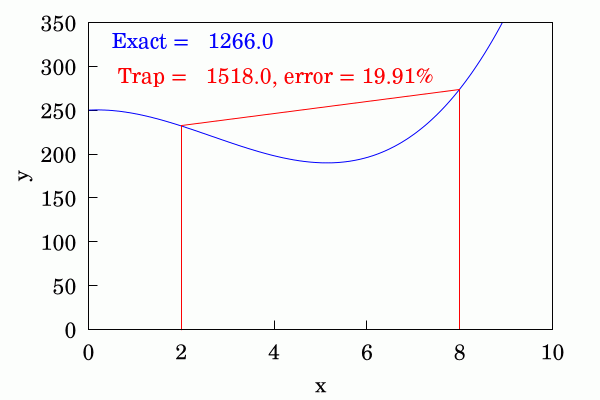

In [273]:
storage_1 =np.trapz(vwc_1, depths)/100
print(storage_1,"cm of water in may 4 2021")

33.914477875 cm of water in may 4 2021


In [274]:
vwc_2 = df["2021-05-15"].values.astype(float) # volumetric water content
storage_2 = np.trapz(vwc_2,depths)/100 # total profile soil water storage in cm

print(storage_2,"cm of water may 15-2009")

32.33339076041666 cm of water may 15-2009


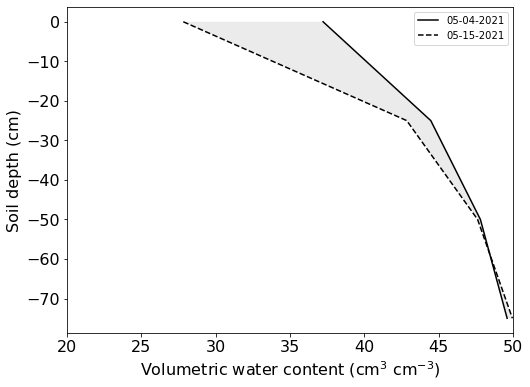

In [275]:
import matplotlib.pyplot as plt

# Plot profile
plt.figure(figsize=(8,6))
plt.plot(vwc_1,depths*-1, '-k', label="05-04-2021")
plt.plot(vwc_2,depths*-1, '--k', label="05-15-2021")

plt.xlabel('Volumetric water content (cm$^3$ cm$^{-3}$)', size=16)
plt.ylabel('Soil depth (cm)', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.fill_betweenx(depths*-1, vwc_1, vwc_2,vwc_3,facecolor=(0.7,0.7,0.7), alpha=0.25)
plt.xlim(20,50)
plt.show()

In [276]:
# Compute total soil water storage for each date
storage = np.array([])
for date in range(1,len(df.columns)):
    storage_date = np.round(np.trapz(df.iloc[:,date], depths), 2)
    storage = np.append(storage,storage_date)
    
storage

array([3342.76, 3331.76, 3310.29, 3308.43, 3290.9 , 3290.77, 3271.6 ,
       3261.04, 3257.14, 3241.15, 3233.34, 3222.  , 3224.85, 3223.57,
       3206.84, 3198.92, 3173.26, 3168.65, 3148.6 , 3148.94, 3142.2 ,
       3127.65, 3107.89, 3067.46, 3048.82, 2997.99, 3016.33, 2956.06,
       2952.74, 3058.72, 3069.79, 2983.57, 3000.05, 2954.56, 3026.44,
       3047.3 , 3052.18, 3000.13, 3036.31, 2968.46, 3033.67, 3047.63,
       3042.17, 3032.36, 3020.75, 3010.3 , 3001.64, 2981.46, 3019.47,
       3042.41, 3053.23, 3055.85, 2971.4 , 3007.44, 2928.69, 2979.85,
       3000.15, 2917.85, 2953.09, 2937.97, 2933.24, 2928.92, 2919.17,
       2909.36, 2903.18, 2902.64, 2895.25, 2869.28, 2849.76, 2852.91,
       2907.45, 2849.54, 2827.01, 2845.21, 2794.01, 2752.91, 2718.19,
       2531.28, 2398.5 , 2740.56, 2811.27, 2691.72, 2765.85, 2763.06,
       2751.01, 2612.91, 2713.74, 2811.69, 2862.1 , 2908.74, 2942.22,
       2971.94, 2902.11, 2922.54, 3004.26, 3041.78, 3070.22, 3103.37,
       3130.44, 3066

In [277]:
 #Get measurement dates and convert them to datetime format
obs_dates = pd.to_datetime(df.columns[1:])
obs_delta = obs_dates - obs_dates[0]
obs_seq = obs_delta.days
print(len(obs_seq))

139


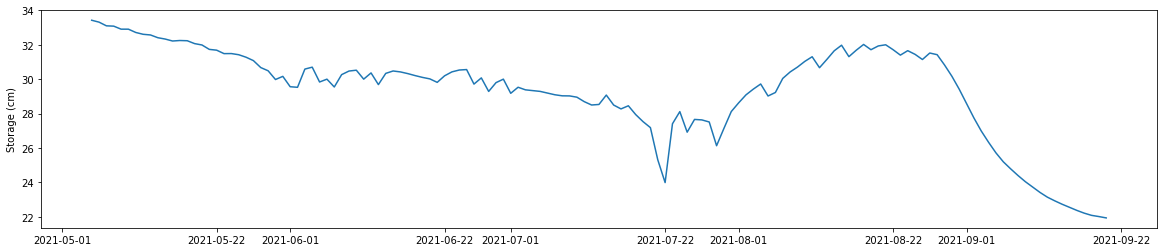

In [278]:
# Plot timeseries of profile soil moisture
plt.figure(figsize=(20,4))
plt.plot(obs_dates, storage/100)
plt.ylabel('Storage (cm)')
plt.show()

In [279]:
# Y values
#y = np.tile(depths*-1,62)
y = np.repeat(depths*-1,139)
y.shape

(556,)

In [280]:
# X values
x = np.tile(obs_seq,4)
x.shape

(556,)

In [281]:
# Z values
z = df.iloc[:,1:].values.flatten()/100
z.shape
z=z.astype(float)

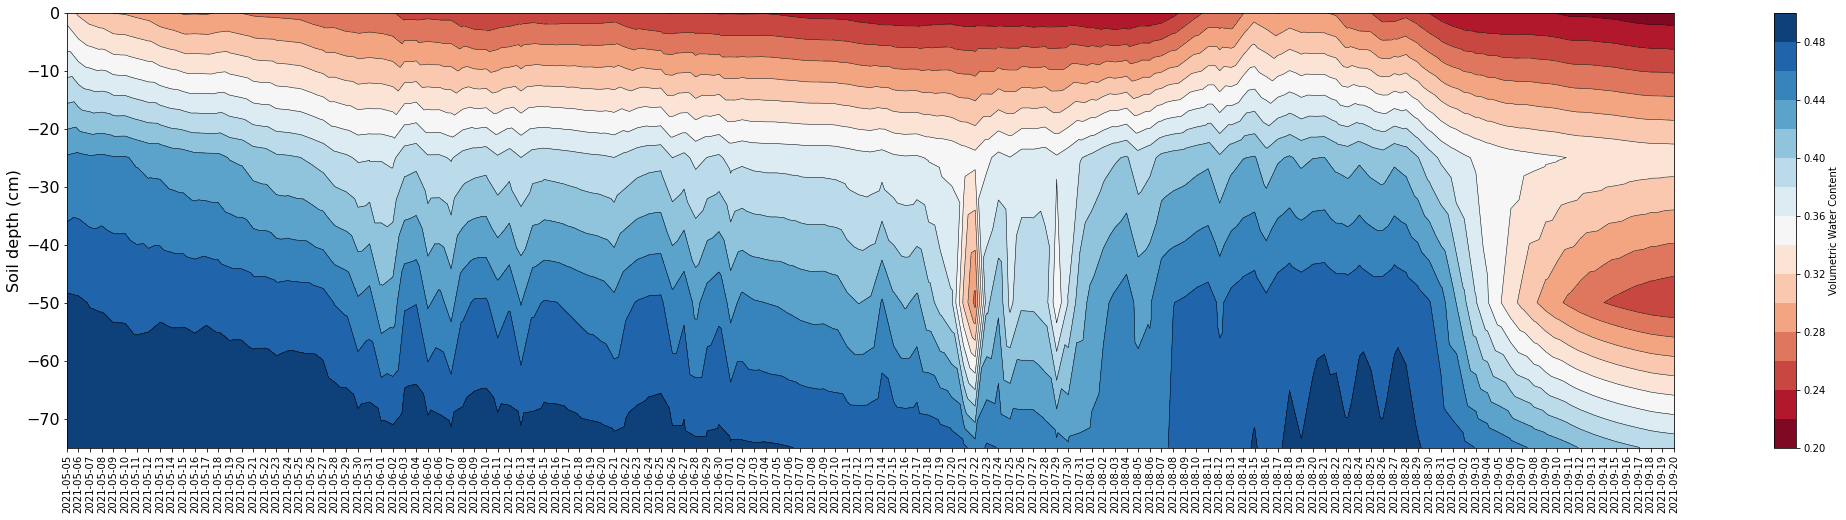

In [282]:
plt.figure(figsize=(36,8))
plt.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
plt.tricontourf(x, y, z, levels=14, cmap="RdBu")
plt.xticks(obs_seq, labels=obs_dates.date, rotation=90)
plt.colorbar(label="Volumetric Water Content")
plt.ylabel('Soil depth (cm)', size=16)
plt.yticks(fontsize=16)
plt.show()

### Soil water Balance

The soil water storage in the rootzone is the result of the balance between water inputs (e.g. precipitation, irrigation) and outputs (e.g. evaporation, runoff). Soil water is always moving which means soil water storage is always changin, at least to small amount, but when we look at soil physical processes over coarser temporal scales we can make some approxiamtion of soil water storage for agricultural applications.

Soil water balance is computed at daily time-step. The soil water storage at the end of the day will be estimated like this:
- S_t = S_{t-1} + P_t + Irr_t - Etc_t - R_t - D_t - I_t

- S_t: is the soil water storage over the rootzone at the end of the day t
- S_(t-1): is the soil water storage at the beginning of the day t
- P is the total precipitation and Irr is the total irrigation during time t .
- I is canopy and litter interception. The P-I is often known as effective precipitation. 
- ETc_T is the crop evapotranspiration at the end of day t
- R is surface runoff ( can be modelled using curve number method
- D is the drainage below the bottom of the rootzone ( Wilcox Method)




### Creating a dataframe ( precipitation,  ETc from Mark2 database, soil moisture  from sentek and irrigation amount from pressure switch) 

In [283]:
## subsetting date, precip, etc and crop_water_demand from Mark2 df
ET100m_sub = mark_daily_ET100[['time', 'precip', 'etc', 'crop_water_demand']]
ET100m_sub['time'] =pd.to_datetime(ET100m_sub['time']).dt.date

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [284]:
ET100m_sub

,time,precip,etc,crop_water_demand
0,2021-05-04,0.0,NaN,0.000000
1,2021-05-05,0.0,1.226393,-1.226393
2,2021-05-06,0.0,1.108632,-1.108632
3,2021-05-07,0.0,1.134255,-1.134255
4,2021-05-08,0.0,1.293436,-1.293437
...,...,...,...,...
135,2021-09-16,0.0,3.471553,-3.471553
136,2021-09-17,0.0,3.694815,-3.694814
137,2021-09-18,0.0,3.588037,-3.588036
138,2021-09-19,0.0,3.867029,-3.867029


In [285]:
## subset irrigation from pulse data
Irrigation = irrigation_daily_ET100[['time','irigation']]
Irrigation['time'] =pd.to_datetime(Irrigation['time']).dt.date

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [286]:
Irrigation

,time,irigation
0,2021-05-07,2.053333
1,2021-05-08,0.000000
2,2021-05-09,2.053333
3,2021-05-10,0.000000
4,2021-05-11,0.000000
...,...,...
108,2021-08-23,6.031667
109,2021-08-24,6.031667
110,2021-08-25,0.000000
111,2021-08-26,6.031667


In [287]:
## subset soil moisture from sentek
soil_moisture= sentek_daily_ET100[['time', 'moisture_0_mean', 'moisture_1_mean', 'moisture_2_mean', 'moisture_3_mean']]

In [288]:
soil_moisture['time']=pd.to_datetime(soil_moisture['time']).dt.date

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [289]:
soil_moisture

,time,moisture_0_mean,moisture_1_mean,moisture_2_mean,moisture_3_mean
0,2021-05-04,37.222057,44.458784,47.792665,49.590868
1,2021-05-05,32.958923,44.196952,48.250882,49.566609
2,2021-05-06,31.695406,44.419958,48.173753,49.658004
3,2021-05-07,30.921996,44.187527,47.940303,49.645766
4,2021-05-08,30.553153,44.327021,47.881652,49.703711
...,...,...,...,...,...
135,2021-09-16,21.248104,33.407974,25.284997,40.312442
136,2021-09-17,21.091134,33.285107,24.988830,40.024646
137,2021-09-18,21.003872,33.203288,24.739479,39.744118
138,2021-09-19,20.991538,33.185157,24.575339,39.558713


In [290]:
### merge mark2, sentek and pulse data into one dataframe

In [291]:
from functools import reduce
dfs = [ET100m_sub,Irrigation, soil_moisture]
df_merged = reduce(lambda left,right: pd.merge(left,right,on='time'), dfs)

In [292]:
df_merged

,time,precip,etc,crop_water_demand,irigation,moisture_0_mean,moisture_1_mean,moisture_2_mean,moisture_3_mean
0,2021-05-07,0.00,1.134255,-1.134255,2.053333,30.921996,44.187527,47.940303,49.645766
1,2021-05-08,0.00,1.293436,-1.293437,0.000000,30.553153,44.327021,47.881652,49.703711
2,2021-05-09,0.00,1.329451,-1.329451,2.053333,29.935075,44.100822,47.724215,49.686671
3,2021-05-10,0.00,1.368190,-1.368190,0.000000,29.831826,44.129371,47.707941,49.754979
4,2021-05-11,0.00,1.421883,-1.421883,0.000000,29.514341,43.741909,47.507195,49.715243
...,...,...,...,...,...,...,...,...,...
108,2021-08-23,0.00,4.592071,-4.592071,6.031667,26.433288,41.134750,47.132306,48.224805
109,2021-08-24,0.09,5.040887,-4.950887,6.031667,26.015203,41.701465,47.497090,48.850021
110,2021-08-25,0.00,5.126782,-5.126782,0.000000,25.964038,41.157506,47.145498,48.977511
111,2021-08-26,0.00,5.445108,-5.445108,6.031667,24.989910,40.833515,47.139246,48.214440


In [ ]:
### pull soil texture from SURGOO database


#### get soil input from SUGGOR ( USGS Soil Survey)

In [294]:
import numpy as np
import pandas as pd

In [295]:
#%pip install xmltodict

Note: you may need to restart the kernel to use updated packages.


In [296]:
#!pip install --upgrade -q pygsheets

###### MU Key from Lat Long using Soil Data Mart

In [301]:
import requests
import xmltodict

def mukey_from_latlong(lat, long):

  lat0 = lat
  long0 = long
  lat1 = lat0+0.00001
  long1 = long0+0.00001


  url = 'https://sdmdataaccess.nrcs.usda.gov/Spatial/SDMWGS84Geographic.wfs'
  filter = '<Filter><BBOX><PropertyName>Geometry</PropertyName><Box srsName=\'EPSG:4326\'><coordinates>{0},{1} {2},{3}</coordinates></Box></BBOX></Filter>'.format(long0, lat0, long1, lat1)

  params = {'SERVICE': 'WFS', 
            'VERSION': '1.1.0',
            'REQUEST': 'GetFeature',
            'TYPENAME': 'MapunitPoly',
            'FILTER': filter
           }
  
  r = requests.get(url, params=params)
  
  if r.status_code == 200:
    doc = xmltodict.parse(r._content)
    mukey = doc['wfs:FeatureCollection']['gml:featureMember']['ms:mapunitpoly']['ms:mukey']
    return mukey

  else:
    return -9999
  
  

In [302]:

lat = 38.53828
long = -121.78273


#west
mukey = mukey_from_latlong(lat, long)

print (mukey)

459308


#### Soil properties from MUKEY

In [303]:
import json

def soiltex_from_mukey(mukey):

  url = 'https://SDMDataAccess.sc.egov.usda.gov/Tabular/post.rest'

  query = """SELECT
  hzdept_r, hzdepb_r, sandtotal_r, silttotal_r, claytotal_r
  FROM sacatalog sac
  INNER JOIN legend l ON l.areasymbol = sac.areasymbol AND l.areatypename = 'Non-MLRA Soil Survey Area'
  INNER JOIN mapunit mu ON mu.lkey = l.lkey
  AND mu.mukey IN ('{0}')
  LEFT OUTER JOIN component c ON c.mukey = mu.mukey
  LEFT OUTER JOIN chorizon ch ON ch.cokey = c.cokey
  LEFT OUTER JOIN chtexturegrp chtgrp ON chtgrp.chkey = ch.chkey
  LEFT OUTER JOIN chtexture cht ON cht.chtgkey = chtgrp.chtgkey
  LEFT OUTER JOIN chtexturemod chtmod ON chtmod.chtkey = cht.chtkey  

  WHERE chtgrp.rvindicator = 'Yes' AND hzdept_r <= 90
  ORDER BY hzdept_r ASC""".format(mukey)

  data = {
            'QUERY': query,
            'FORMAT': 'JSON+COLUMNNAME'
           }



  r = requests.post(url, data = data)
  
  d = json.loads(r._content)
  
  df = pd.DataFrame(d['Table'][1:], columns=d['Table'][0])
  
  df['hzdept_r'] = df['hzdept_r'].astype('float64')
  df['hzdepb_r'] = df['hzdepb_r'].astype('float64')
  df['sandtotal_r'] = df['sandtotal_r'].astype('float64')
  df['silttotal_r'] = df['silttotal_r'].astype('float64')
  df['claytotal_r'] = df['claytotal_r'].astype('float64')
  
  return df

In [304]:
soiltex = soiltex_from_mukey(mukey)
soiltex

,hzdept_r,hzdepb_r,sandtotal_r,silttotal_r,claytotal_r
0,0.0,5.0,7.0,68.0,25.0
1,5.0,20.0,7.0,67.0,26.0
2,20.0,48.0,7.0,67.0,26.0
3,48.0,66.0,7.0,67.0,26.0
4,66.0,84.0,7.0,68.0,25.0
5,84.0,104.0,7.0,70.0,23.0


#### Components from MUKEY

In [305]:
def components_from_mukey(mukey):

  url = 'https://SDMDataAccess.sc.egov.usda.gov/Tabular/post.rest'

  query = """SELECT
  saversion, saverest, 
  l.areasymbol, l.areaname, l.lkey, 
  musym, muname, museq, mu.mukey, 
  comppct_r, compname, localphase, slope_r, c.cokey
  FROM sacatalog sac
  INNER JOIN legend l ON l.areasymbol = sac.areasymbol AND l.areatypename = 'Non-MLRA Soil Survey Area'
  INNER JOIN mapunit mu ON mu.lkey = l.lkey
  AND mu.mukey IN ('{0}')
  LEFT OUTER JOIN component c ON c.mukey = mu.mukey

  ORDER BY comppct_r DESC""".format(mukey)

  data = {
            'QUERY': query,
            'FORMAT': 'JSON+COLUMNNAME'
           }



  r = requests.post(url, data = data)
  
  d = json.loads(r._content)
  
  df = pd.DataFrame(d['Table'][1:], columns=d['Table'][0])
  
  return df

In [306]:
components = components_from_mukey(mukey)
components

,saversion,saverest,areasymbol,areaname,lkey,musym,muname,museq,mukey,comppct_r,compname,localphase,slope_r,cokey
0,17,9/6/2021 8:43:50 PM,CA113,"Yolo County, California",14091,Ya,"Yolo silt loam, 0 to 2 percent slopes, MLRA 17",130,459308,85,Yolo,None,0,21463791
1,17,9/6/2021 8:43:50 PM,CA113,"Yolo County, California",14091,Ya,"Yolo silt loam, 0 to 2 percent slopes, MLRA 17",130,459308,3,Arbuckle,None,None,21463788
2,17,9/6/2021 8:43:50 PM,CA113,"Yolo County, California",14091,Ya,"Yolo silt loam, 0 to 2 percent slopes, MLRA 17",130,459308,2,Loamy alluvial land,None,None,21463789
3,17,9/6/2021 8:43:50 PM,CA113,"Yolo County, California",14091,Ya,"Yolo silt loam, 0 to 2 percent slopes, MLRA 17",130,459308,2,Zamora,None,None,21463790
4,17,9/6/2021 8:43:50 PM,CA113,"Yolo County, California",14091,Ya,"Yolo silt loam, 0 to 2 percent slopes, MLRA 17",130,459308,2,Soboba,None,None,21463785
5,17,9/6/2021 8:43:50 PM,CA113,"Yolo County, California",14091,Ya,"Yolo silt loam, 0 to 2 percent slopes, MLRA 17",130,459308,2,Brentwood,None,None,21463786
6,17,9/6/2021 8:43:50 PM,CA113,"Yolo County, California",14091,Ya,"Yolo silt loam, 0 to 2 percent slopes, MLRA 17",130,459308,2,Sycamore,None,None,21463787
7,17,9/6/2021 8:43:50 PM,CA113,"Yolo County, California",14091,Ya,"Yolo silt loam, 0 to 2 percent slopes, MLRA 17",130,459308,2,Reiff,None,None,21463792


In [307]:
components.compname

0                   Yolo
1               Arbuckle
2    Loamy alluvial land
3                 Zamora
4                 Soboba
5              Brentwood
6               Sycamore
7                  Reiff
Name: compname, dtype: object

In [308]:
import os
import glob

### Apply Saxton Calculator to soil texture

In [309]:
import numpy as np

def waterholding_from_soiltex(df, format=None):
  """
  
  Reference:
  K.E. Saxton et al., 1986 
  Estimating generalized soil-water characteristics from texture.  Soil Sci. Soc. Amer. J. 50(4):1031-1036

  https://www2.nrel.colostate.edu/projects/century/soilCalculatorHelp.htm
  """
  
  # Calculate column Averages
  # Currently goes beyond 90cm; should take optional parameter for soil depth and handling
  df['thick'] = df.hzdepb_r - df.hzdept_r
  
  sand = np.sum(df['sandtotal_r']*df['thick'])/np.sum(df['thick'])
  clay = np.sum(df['claytotal_r']*df['thick'])/np.sum(df['thick'])
  
  # Calculate soil properties
  pctsand = sand
  pctclay = clay

  acoef = np.exp(-4.396 - 0.0715 * pctclay - 4.88e-4 * (pctsand**2.) - 4.285e-5 * (pctsand**2.) * pctclay)

  bcoef = (-3.14 - 0.00222 * (pctclay**2.) - 3.484e-5 * (pctsand**2.) * pctclay)
  sat = (0.332 - 7.251e-4 * pctsand + 0.1276 * np.log10(pctclay))

  wp_raw = (15.0 / acoef)**(1.0 / bcoef)
  fc_raw = (0.33333 / acoef)**(1.0 / bcoef)
  ksat_raw = np.exp((12.012 - 0.0755 * pctsand) + (-3.895 + 0.03671 * \
             pctsand - 0.1103 * pctclay + 8.7546e-4 * (pctclay**2.)) / sat)
  bd_raw = (1 - sat) * 2.65

  wltptorig = wp_raw
  fieldcorig= fc_raw


  # Corrections from Steve Del Grosso 

  wiltpt = wp_raw + (-0.15 * wp_raw)
  fieldc = fc_raw + (0.07 * fc_raw)
  ksat = ksat_raw / 1500
  bulkd = bd_raw + (-0.08 * bd_raw)
  
  # If format = tableau
  if format == "tableau":
    wiltpt = wiltpt*100*9
    fieldc = fieldc*100*9
  
  return fieldc.round(3), wiltpt.round(3), (fieldc-wiltpt).round(3)

In [310]:
fieldc, wiltpt, availwater = waterholding_from_soiltex(soiltex)
##remove format=tableau for original values

In [311]:
fieldc, wiltpt, availwater

(0.347, 0.12, 0.226)

### All together now

In [314]:
lat = 38.53828
long = -121.78273

fieldc, wiltpt, availwater = waterholding_from_soiltex(soiltex_from_mukey(mukey_from_latlong(lat, long)))

print (fieldc, wiltpt, availwater)



0.347 0.12 0.226
